Доржиев А.С. АБД19-1М

* EDA (с картинками)
* Наличие персептрона
* Добавление новых признаков
* Проверка результата с помощью Catboost или любого другого классификатора
* Выводы
* Рекомендации

Классификация: больше средней суммы - даем (np.mean(credit_amount))

In [ ]:
import tensorflow

In [ ]:
from keras import metrics

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD 
from keras.utils import np_utils

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
PATH = "/content/drive/My Drive/Нейронные сети 1_Модуль_2020/"

In [ ]:
df = pd.read_csv(PATH+'german_credit_data.csv', index_col=[0])
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
def fn_get_info(df):
  # Информация по столбцам
  return pd.DataFrame(
          {'Feature': df.columns.tolist(),
           'NaN_count': df.isna().sum().tolist(),
           'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
           'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)})

In [ ]:
fn_get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,Age,0,53,int64
1,Sex,0,2,object
2,Job,0,4,int64
3,Housing,0,3,object
4,Saving accounts,183,4,object
5,Checking account,394,3,object
6,Credit amount,0,921,int64
7,Duration,0,33,int64
8,Purpose,0,8,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [ ]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
df['Saving accounts'] = df['Saving accounts'].fillna('Others')
df['Checking account'] = df['Checking account'].fillna('Others')

In [ ]:
# добавим таргет для задачи классификации
df['target'] = 1
df['target'][df['Credit amount'] < np.mean(df['Credit amount'])] = 0
df=df.drop(columns='Credit amount') 
df.head()

NameError: ignored

In [ ]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,target
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,1


In [ ]:
df.shape

(1000, 10)

In [ ]:
df['target'].value_counts()

0    658
1    342
Name: target, dtype: int64

## Построение персептрона

In [ ]:
import numpy as np 
import pandas as pd

from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from keras.layers import Dense, Dropout

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype # 

In [ ]:
data = df

In [ ]:
# Нормализация
def normalize(df):
    result = df.copy()
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

In [ ]:
labels = data.columns
# Идем по колонкам
for col in labels:
    if is_string_dtype(data[col]):
        # Факторизуем таргет
        if col == 'target': 
            data[col] = pd.factorize(data[col])[0]
            continue
        # Кодируем категориальные данные 
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
        data.drop(col, axis=1, inplace=True)
    else:
        data[col] = normalize(data[col]) # Нормализуем численные данные 

# move 'target' back to the end of the df
data = data[[c for c in data if c not in ['target']] + ['target']]

data_train = data.iloc[:800]
data_valid = data.iloc[800:]
x_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
x_val = data_valid.iloc[:,:-1]
y_val = data_valid.iloc[:,-1]

In [ ]:
x_train.shape

(800, 24)

In [ ]:
x_train.head()

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0.857143,0.666667,0.050567,0.029412,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.053571,0.666667,0.313690,0.647059,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.535714,0.333333,0.101574,0.117647,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.464286,0.666667,0.419941,0.558824,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.607143,0.666667,0.254209,0.294118,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.value_counts()

0.0    538
1.0    262
Name: target, dtype: int64

In [ ]:
y_val.value_counts()

0.0    120
1.0     80
Name: target, dtype: int64

### Многослойный персептрон 

In [ ]:
# Определим опитимизатор 
sgd = optimizers.SGD(lr=0.03, decay=0, momentum=0.9, nesterov=False)

model = Sequential()
model.add(Dense(units=50, activation='tanh', input_dim=24)) #, kernel_initializer='glorot_normal', bias_initializer='zeros'))
model.add(Dropout(0.35))
model.add(Dense(units=1, activation='sigmoid')) # , kernel_initializer='glorot_normal', bias_initializer='zeros'))

In [ ]:
# Компилляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Обучение модели
model.fit(x_train.values, y_train.values, validation_data=(x_val.values, y_val.values), epochs=30, batch_size=128)

Epoch 1/30
7/7 [==============================] - 0s 18ms/step - loss: 0.6724 - accuracy: 0.5875 - val_loss: 0.6441 - val_accuracy: 0.6150
Epoch 2/30
7/7 [==============================] - 0s 5ms/step - loss: 0.6249 - accuracy: 0.6675 - val_loss: 0.6365 - val_accuracy: 0.6150
Epoch 3/30
7/7 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.6650 - val_loss: 0.6376 - val_accuracy: 0.6100
Epoch 4/30
7/7 [==============================] - 0s 6ms/step - loss: 0.6022 - accuracy: 0.6888 - val_loss: 0.6319 - val_accuracy: 0.6150
Epoch 5/30
7/7 [==============================] - 0s 6ms/step - loss: 0.5865 - accuracy: 0.6900 - val_loss: 0.6235 - val_accuracy: 0.6250
Epoch 6/30
7/7 [==============================] - 0s 5ms/step - loss: 0.5805 - accuracy: 0.6975 - val_loss: 0.6092 - val_accuracy: 0.6350
Epoch 7/30
7/7 [==============================] - 0s 5ms/step - loss: 0.5697 - accuracy: 0.7175 - val_loss: 0.5949 - val_accuracy: 0.6650
Epoch 8/30
7/7 [=================

## Оценка модели

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score
import seaborn as sns

In [ ]:
# Определяем значения таргетов - предсказание 
y_pred = model.predict_classes(x_val.values)
y_val = y_val.values

Precision Score on validation data is 0.783916083916084


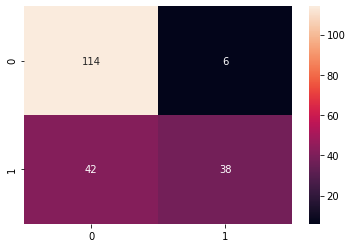

In [ ]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='.5g') 
print('Precision Score on validation data is {}'.format(precision_score(y_val, y_pred, average='weighted')))

### Попробуем оптимизатор SGD

In [ ]:
data_train = data.iloc[:800]
data_valid = data.iloc[800:]
x_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
x_val = data_valid.iloc[:,:-1]
y_val = data_valid.iloc[:,-1]

In [ ]:
# Компилляция модели
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Обучение модели
model.fit(x_train.values, y_train.values, validation_data=(x_val.values, y_val.values), epochs=30, batch_size=128)

Epoch 1/30
7/7 [==============================] - 0s 17ms/step - loss: 0.4317 - accuracy: 0.8163 - val_loss: 0.4601 - val_accuracy: 0.7600
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 0.4230 - accuracy: 0.8250 - val_loss: 0.4457 - val_accuracy: 0.7550
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 0.4142 - accuracy: 0.8188 - val_loss: 0.4411 - val_accuracy: 0.7550
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 0.3984 - accuracy: 0.8275 - val_loss: 0.4226 - val_accuracy: 0.7800
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 0.3919 - accuracy: 0.8413 - val_loss: 0.4121 - val_accuracy: 0.7900
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 0.3758 - accuracy: 0.8400 - val_loss: 0.4053 - val_accuracy: 0.7950
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8462 - val_loss: 0.3910 - val_accuracy: 0.8050
Epoch 8/30
7/7 [=================

In [ ]:
# Определяем значения таргетов - предсказание 
y_pred = model.predict_classes(x_val.values)
y_val = y_val.values

Precision Score on validation data is 0.8933611400764684


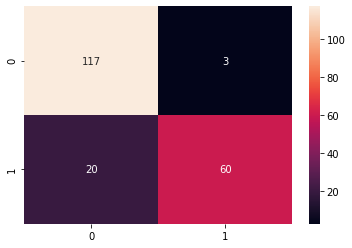

In [ ]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='.5g') 
print('Precision Score on validation data is {}'.format(precision_score(y_val, y_pred, average='weighted')))

### Увеличим кол-во эпох обучения

In [ ]:
data_train = data.iloc[:800]
data_valid = data.iloc[800:]
x_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
x_val = data_valid.iloc[:,:-1]
y_val = data_valid.iloc[:,-1]

In [ ]:
# Компилляция модели
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Обучение модели
model.fit(x_train.values, y_train.values, validation_data=(x_val.values, y_val.values), epochs=100, batch_size=128)

Epoch 1/100
7/7 [==============================] - 0s 16ms/step - loss: 0.2217 - accuracy: 0.9175 - val_loss: 0.2512 - val_accuracy: 0.8700
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2234 - accuracy: 0.9125 - val_loss: 0.2513 - val_accuracy: 0.8800
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2036 - accuracy: 0.9225 - val_loss: 0.2393 - val_accuracy: 0.8800
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2075 - accuracy: 0.9237 - val_loss: 0.2411 - val_accuracy: 0.8750
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2037 - accuracy: 0.9250 - val_loss: 0.2317 - val_accuracy: 0.8800
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2040 - accuracy: 0.9200 - val_loss: 0.2365 - val_accuracy: 0.8850
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1977 - accuracy: 0.9250 - val_loss: 0.2220 - val_accuracy: 0.8950
Epoch 8/100
7/7 [=========

In [ ]:
# Определяем значения таргетов - предсказание 
y_pred = model.predict_classes(x_val.values)
y_val = y_val.values

Precision Score on validation data is 0.9435164835164835


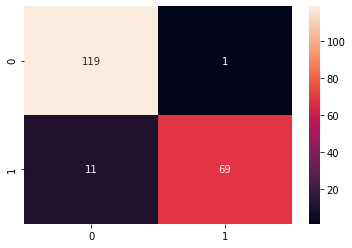

In [ ]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='.5g') 
print('Precision Score on validation data is {}'.format(precision_score(y_val, y_pred, average='weighted')))